In [24]:
%run init_notebook.py

In [25]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby

In [26]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank
from statsmodels.tsa.stattools import adfuller

# load

In [27]:
topics = load_pd_df('lda_topics_smooth.feather').reset_index()
topics['date'] = topics['date'].apply(lambda x: datetime(x.year, x.month, x.day))
# topics = topics.set_index('date').join(pd.DataFrame(dict_smoothed, index=tlda.date.drop_duplicates()).add_suffix('_s'), how='left')
topics.set_index('date', inplace=True)

hhp = load_pd_df('hhp_processed.feather')
pi = get_dt_index(load_pd_df('de_inf_prepro.csv')).sort_index()
mir = get_dt_index(load_pd_df('mir.csv'))

In [21]:
df = pd_join_dfs(
    [
        pi[['pi_de', 'pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y']],
        hhp.set_index('date_recorded')[
            ['date_forecast', 'pi_exp_WY', 'pi_exp_MY', 'pi_perc_MY', 'pi_perc_WY', 'hhinc_delta', 'delta_pe_WY', 'id']
        ],
        topics.drop('id', axis=1), #[[i for i in topics.columns if i.split('_')[-1] == "s"]],
        mir,
    ],
    index_name='date_recorded'
)

## Does surprise inflation elicit higher news-paper reporting?

In [22]:
sub = pd_groupby(
    df, 
    ["pi_perc_WY", "ecb_rate", "D_inflation"],
    'M', 'last').drop_duplicates().dropna()
sub.shape

(37, 3)

<AxesSubplot: xlabel='M'>

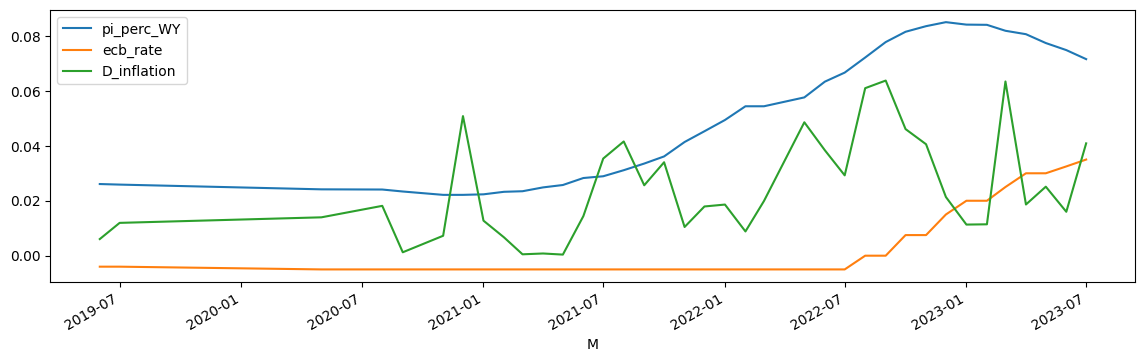

In [23]:
sub.plot(figsize=(14,4))

In [69]:
for i in sub:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")

inflation_s ADF p-val: 0.9623486753993961
pi_perc_WY ADF p-val: 0.22733055722493378


In [70]:
var = VAR(sub).fit()
var.summary()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 06, Mar, 2024
Time:                     15:48:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -21.6581
Nobs:                     39.0000    HQIC:                  -21.8223
Log likelihood:           322.647    FPE:                3.04158e-10
AIC:                     -21.9141    Det(Omega_mle):     2.62259e-10
--------------------------------------------------------------------
Results for equation inflation_s
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.003984         0.002635            1.512           0.131
L1.inflation_s         0.550817         0.132971            4.142           0.000
L1.pi_perc_WY          0.214384         0.074978  

In [71]:
jtest = select_coint_rank(sub, -1, 15, method="maxeig", signif=0.05)
print(jtest.summary())
jtest.rank

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          13.38          11.22
  1   2          1.047          4.130
-------------------------------------


1

In [72]:
vecm = VECM(sub, coint_rank=jtest.rank).fit()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [73]:
vecm.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.inflation_s,0.3239,0.149,2.177,0.030,0.032,0.616
L1.pi_perc_WY,-0.5027,0.375,-1.341,0.180,-1.238,0.232
,coef,std err,z,P>|z|,[0.025,0.975]
L1.inflation_s,0.0212,0.039,0.542,0.588,-0.056,0.098
L1.pi_perc_WY,0.8263,0.099,8.362,0.000,0.633,1.020
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.5132,0.127,-4.033,0.000,-0.763,-0.264
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,0.0146,0.034,0.436,0.663,-0.051,0.080
,coef,std err,z,P>|z|,[0.025,0.975]


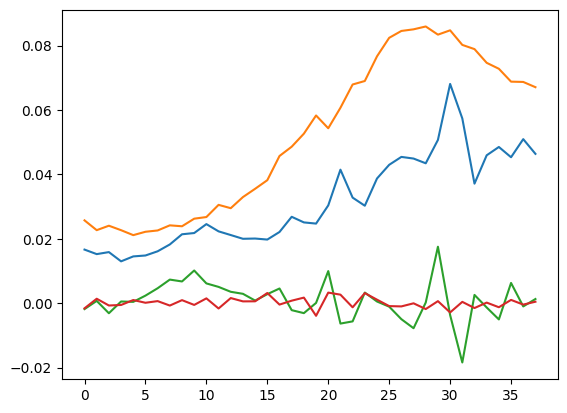

In [75]:
plt.plot(vecm.fittedvalues)
plt.plot(vecm.resid)